# RTS vs BIFM Smoothing


___Credits to Martin de Quincey___

This notebook performs Kalman smoothing on a factor graph using message passing, based on the BIFM Kalman smoother. This notebook is based on:

1. F. Wadehn, “State Space Methods with Applications in Biomedical Signal Processing,” ETH Zurich, 2019. Accessed: Jun. 16, 2021. [Online]. Available: https://www.research-collection.ethz.ch/handle/20.500.11850/344762
2. H. Loeliger, L. Bruderer, H. Malmberg, F. Wadehn, and N. Zalmai, “On sparsity by NUV-EM, Gaussian message passing, and Kalman smoothing,” in 2016 Information Theory and Applications Workshop (ITA), Jan. 2016, pp. 1–10. doi: 10.1109/ITA.2016.7888168.

We perform Kalman smoothing in the linear state space model, represented by:

$$\begin{aligned}
    Z_{k+1} &= A Z_k + B U_k \\
    Y_k &= C Z_k + W_k
\end{aligned}$$

with observations $Y_k$, latent states $Z_k$ and inputs $U_k$. $W_k$ is the observation noise. $A \in \mathrm{R}^{n \times n}$, $B \in \mathrm{R}^{n \times m}$ and $C \in \mathrm{R}^{d \times n}$ are the transition matrices in the model. Here $n$, $m$ and $d$ denote the dimensionality of the latent, input and output dimension, respectively.

The corresponding probabilistic model can be represented as 

$$\begin{aligned}
        p(y,\ z,\ u)
        &= p(z_0) \prod_{k=1}^N p(y_k \mid z_k)\ p(z_k\mid z_{k-1},\ u_{k-1})\ p(u_{k-1}) \\
        &= \mathcal{N}(z_0 \mid \mu_{z_0}, \Sigma_{z_0}) \left( \prod_{k=1}^N \mathcal{N}(y_k \mid C z_k,\ \Sigma_W)\ \delta(z_k - (Az_{k-1} + Bu_{k-1})) \mathcal{N}(u_{k-1} \mid \mu_{i_{k-1}},\ \Sigma_{u_{k-1}}) \right)
\end{aligned}$$

## Import packages

In [1]:
using RxInfer, Random, LinearAlgebra, BenchmarkTools, ProgressMeter, Plots, StableRNGs

## Data generation

In [ ]:
function generate_parameters(dim_out::Int64, dim_in::Int64, dim_lat::Int64; seed::Int64 = 123)
    
    # define noise levels
    input_noise  = 500.0
    output_noise = 50.0

    # create random generator for reproducibility
    rng = StableRNG(seed)

    # generate matrices, input statistics and noise matrices
    A      = diagm(0.8 .* ones(dim_lat) .+ 0.2 * rand(rng, dim_lat))                                            # size (dim_lat x dim_lat)
    B      = rand(rng, dim_lat, dim_in)                                                                         # size (dim_lat x dim_in)
    C      = rand(rng, dim_out, dim_lat)                                                                        # size (dim_out x dim_lat)
    μu     = rand(rng, dim_in) .* collect(1:dim_in)                                                             # size (dim_in x 1)
    Σu     = input_noise  .* collect(Hermitian(randn(rng, dim_in, dim_in) + diagm(10 .+ 10*rand(rng, dim_in))))      # size (dim_in x dim_in)
    Σy     = output_noise .* collect(Hermitian(randn(rng, dim_out, dim_out) + diagm(10 .+ 10*rand(rng, dim_out))))   # size (dim_out x dim_out)
    Wu     = inv(Σu)
    Wy     = inv(Σy)
    
    # return parameters
    return A, B, C, μu, Σu, Σy, Wu, Wy

end;

In [4]:
function generate_data(nr_samples::Int64, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Σu::Array{Float64,2}, Σy::Array{Float64,2}; seed::Int64 = 123)
        
    # create random data generator
    rng = StableRNG(seed)
    
    # preallocate space for variables
    z = Vector{Vector{Float64}}(undef, nr_samples)
    y = Vector{Vector{Float64}}(undef, nr_samples)
    u = rand(rng, MvNormal(μu, Σu), nr_samples)'
    
    # set initial value of latent states
    z_prev = zeros(size(A,1))
    
    # generate data
    for i in 1:nr_samples

        # generate new latent state
        z[i] = A * z_prev + B * u[i,:]

        # generate new observation
        y[i] = C * z[i] + rand(rng, MvNormal(zeros(dim_out), Σy))
        
        # generate new observation
        z_prev .= z[i]
        
    end
    
    # return generated data
    return z, y, u
    
end

generate_data (generic function with 1 method)

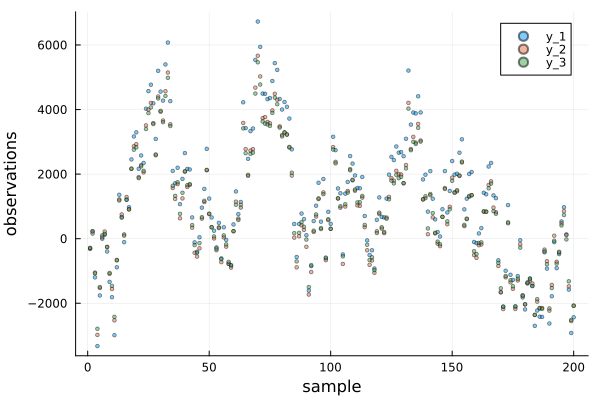

In [5]:
# specify settings
nr_samples = 200
dim_out = 3
dim_in = 3
dim_lat = 25
seed = 42

# generate parameters
A, B, C, μu, Σu, Σy, Wu, Wy = generate_parameters(dim_out, dim_in, dim_lat; seed = seed);
            
# generate data
data_z, data_y, data_u = generate_data(nr_samples, A, B, C, μu, Σu, Σy);

# visualise data
p = Plots.plot(xlabel = "sample", ylabel = "observations")
# plot each dimension independently
for i in 1:dim_out
    Plots.scatter!(p, getindex.(data_y, i), label = "y_$i", alpha = 0.5, ms = 2)
end
p

## Model specification

In [6]:
@model function RTS_smoother(y, A, B, C, μu, Wu, Wy)
    
    # fetch dimensionality
    dim_lat = size(A, 1)
    dim_out = size(C, 1)
    
    # set initial hidden state
    z_prev ~ MvNormal(mean = zeros(dim_lat), precision = 1e-5*diagm(ones(dim_lat)))

    # loop through observations
    for i in eachindex(y)

        # specify input as random variable
        u[i] ~ MvNormal(mean = μu, precision = Wu)
        
        # specify updated hidden state
        z[i] ~ A * z_prev + B * u[i]
        
        # specify observation
        y[i] ~ MvNormal(mean = C * z[i], precision = Wy)
        
        # update last/previous hidden state
        z_prev = z[i]

    end
end

In [7]:
@model function BIFM_smoother(y, A, B, C, μu, Wu, Wy)

    # fetch dimensionality
    dim_lat = size(A, 1)
    
    # set priors
    z_prior ~ MvNormal(mean = zeros(dim_lat), precision = 1e-5*diagm(ones(dim_lat)))
    z[1]  ~ BIFMHelper(z_prior)
    
    # loop through observations
    for i in eachindex(y)

        # specify input as random variable
        u[i]   ~ MvNormal(mean = μu, precision = Wu)

        # specify observation
        yt[i]  ~ BIFM(u[i], z[i], new(z[i+1])) where { meta = BIFMMeta(A, B, C) }
        y[i]   ~ MvNormal(mean = yt[i], precision = Wy)
    end
    
    # set final value
    z[end] ~ MvNormal(mean = zeros(dim_lat), precision = zeros(dim_lat, dim_lat))
end

@constraints function bifm_constraint()
    q(z_prior,z) = q(z_prior)q(z)
end

bifm_constraint (generic function with 1 method)

## Probabilistic inference

In [8]:
function inference_RTS(data_y, A, B, C, μu, Wu, Wy)
    
    # In this task the inference is unstable and can diverge
    meta = @meta begin 
        *() -> ReactiveMP.MatrixCorrectionTools.ClampSingularValues(tiny, Inf)
    end
    
    result = infer(
        model      = RTS_smoother(A = A, B = B, C = C, μu = μu, Wu = Wu, Wy = Wy),
        data       = (y = data_y, ),
        returnvars = (z = KeepLast(), u = KeepLast()),
        meta = meta
    )
    qs = result.posteriors
    return (qs[:z], qs[:u])
end

inference_RTS (generic function with 1 method)

In [9]:
function inference_BIFM(data_y, A, B, C, μu, Wu, Wy)
    result = infer(
        model      = BIFM_smoother(A = A, B = B, C = C, μu = μu, Wu = Wu, Wy = Wy),
        data       = (y = data_y, ),
        constraints = bifm_constraint(),
        returnvars = (z = KeepLast(), u = KeepLast())
    )
    qs = result.posteriors
    return (qs[:z], qs[:u])
end

inference_BIFM (generic function with 1 method)

## Experiments for 200 observations

In [10]:
z_BIFM, u_BIFM = inference_BIFM(data_y, A, B, C, μu, Wu, Wy)
z_RTS, u_RTS = inference_RTS(data_y, A, B, C, μu, Wu, Wy);

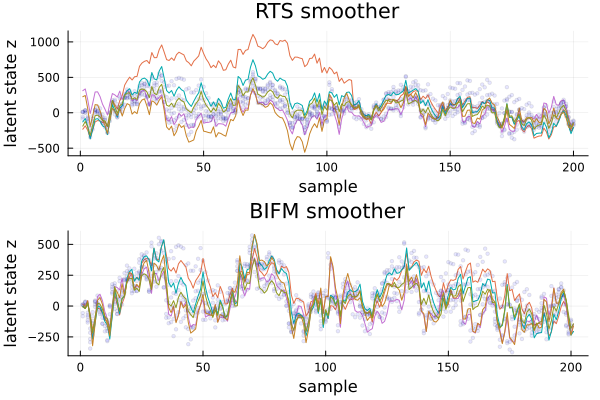

In [11]:
ax1 = Plots.plot(title = "RTS smoother", xlabel = "sample", ylabel = "latent state z")
ax2 = Plots.plot(title = "BIFM smoother", xlabel = "sample", ylabel = "latent state z")

mz_RTS = mean.(z_RTS)
mz_BIFM = mean.(z_BIFM)

# Do not plot all latent states, otherwise the output is just too cluttered
# The main idea here is to check that both algorithms return the (approximately) same output
for i in 1:5
    Plots.scatter!(ax1, getindex.(data_z, i), alpha = 0.1, ms = 2, color = :blue, label = nothing)
    Plots.plot!(ax1, getindex.(mz_RTS, i), label = nothing)
    Plots.scatter!(ax2, getindex.(data_z, i), alpha = 0.1, ms = 2, color = :blue, label = nothing)    
    Plots.plot!(ax2, getindex.(mz_BIFM, i), label = nothing)
end

Plots.plot(ax1, ax2, layout = @layout([ a; b ]))

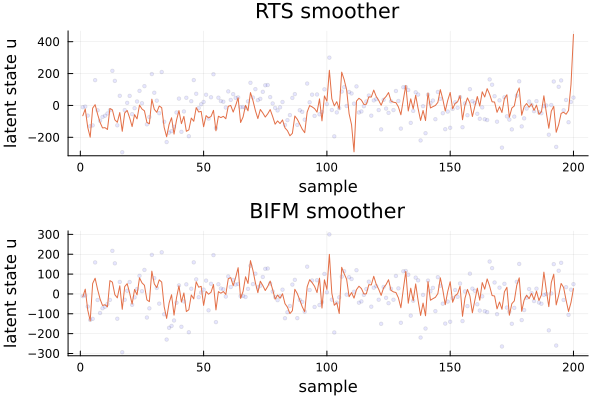

In [12]:
ax1 = Plots.plot(title = "RTS smoother", xlabel = "sample", ylabel = "latent state u")
ax2 = Plots.plot(title = "BIFM smoother", xlabel = "sample", ylabel = "latent state u")

rdata_u = collect(eachrow(data_u))
mu_RTS = mean.(u_RTS)
mu_BIFM = mean.(u_BIFM)

# Do not plot all latent states, otherwise the output is just too cluttered
# The main idea here is to check that both algorithms return the (approximately) same output
for i in 1:1
    Plots.scatter!(ax1, getindex.(rdata_u, i), alpha = 0.1, ms = 2, color = :blue, label = nothing)
    Plots.plot!(ax1, getindex.(mu_RTS, i), label = nothing)
    Plots.scatter!(ax2, getindex.(rdata_u, i), alpha = 0.1, ms = 2, color = :blue, label = nothing)    
    Plots.plot!(ax2, getindex.(mu_BIFM, i), label = nothing)
end

Plots.plot(ax1, ax2, layout = @layout([ a; b ]))

## Benchmark

In [13]:
# This example runs in our documentation pipeline, benchmark executes approximatelly in 20 minutes so we bypass it in the documentation
# For those who are interested in exact benchmark numbers clone this example and set `run_benchmark = true`
run_benchmark = false

if run_benchmark
    trials_range = 30
    trials_n = 500
    trials_RTS  = Array{BenchmarkTools.Trial, 1}(undef, trials_range)
    trials_BIFM = Array{BenchmarkTools.Trial, 1}(undef, trials_range)


    @showprogress for k = 1 : trials_range

        # generate parameters
        local A, B, C, μu, Σu, Σy, Wu, Wy = generate_parameters(3, 3, k);
                    
        # generate data|
        local data_z, data_y, data_u = generate_data(trials_n, A, B, C, μu, Σu, Σy);

        # run inference
        trials_RTS[k] = @benchmark inference_RTS($data_y, $A, $B, $C, $μu, $Wu, $Wy)
        trials_BIFM[k] = @benchmark inference_BIFM($data_y, $A, $B, $C, $μu, $Wu, $Wy)

    end

    m_RTS = [median(trials_RTS[k].times) for k=1:trials_range] ./ 1e9
    q1_RTS = [quantile(trials_RTS[k].times, 0.25) for k=1:trials_range] ./ 1e9
    q3_RTS = [quantile(trials_RTS[k].times, 0.75) for k=1:trials_range] ./ 1e9
    m_BIFM = [median(trials_BIFM[k].times) for k=1:trials_range] ./ 1e9
    q1_BIFM = [quantile(trials_BIFM[k].times, 0.25) for k=1:trials_range] ./ 1e9
    q3_BIFM = [quantile(trials_BIFM[k].times, 0.75) for k=1:trials_range] ./ 1e9;

    p = Plots.plot(ylabel = "duration [sec]", xlabel = "latent state dimension", title = "Benchmark", yscale = :log)
    p = Plots.plot!(p, m_RTS, ribbon = ((q1_RTS .- q3_RTS) ./ 2), color = "blue", label = "mean (RTS)")
    p = Plots.plot!(p, 1:trials_range, m_BIFM, ribbon = ((q1_BIFM .- q3_BIFM) ./ 2), color = "orange", label = "mean (BIFM)")
    Plots.savefig(p, "rts_bifm_benchmark.png")
    p
end

![](rts_bifm_benchmark.png)